# NeuralEE on CORTEX Dataset

`CORTEX` dataset contains 3005 mouse cortex cells and gold-standard labels for seven distinct cell types. Each cell type corresponds to a cluster to recover.

In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import CortexDataset 
from neuralee._aux import scatter

%matplotlib inline

Choose a GPU if a GPU available. It could be defined as follow:
```
device = torch.device('cuda:0')
device = torch.device('cuda:1')
device = torch.device('cpu')
```

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

To reproduce the following results, fix the random seed.

In [3]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

First, we apply log(1 + x) transformation to each element of the cell-gene expression matrix. 
Then, We retain top 558 genes ordered by variance as the original paper. 
Finally, we normalize the expression of each gene by subtracting its mean and dividing its standard deviation.

In [4]:
cortex_dataset = CortexDataset(save_path='../')
cortex_dataset.log_shift()
cortex_dataset.subsample_genes(558)  
cortex_dataset.standardscale()

File ../expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
Downsampling from 19972 to 558 genes


We apply NeuralEE with different hyper-paramters.
`N_small` takes from {1.0, 0.5, 0.25}, while `N_smalls`= 1.0 means not applied with stochastic optimization.
`lam` takes from {1, 10}.
`perplexity` fixs as 30.

Compute affinity, perplexity=30.0, on entire dataset
Compute affinity, perplexity=30.0, N_small=3005, on each batch
Neural Elastic Embedding, lambda=1, completed in 4.62s.
Neural Elastic Embedding, lambda=10, completed in 2.37s.
Compute affinity, perplexity=30.0, N_small=1502, on each batch
Neural Elastic Embedding, lambda=1, completed in 4.18s.
Neural Elastic Embedding, lambda=10, completed in 4.19s.
Compute affinity, perplexity=30.0, N_small=751, on each batch
Neural Elastic Embedding, lambda=1, completed in 8.24s.
Neural Elastic Embedding, lambda=10, completed in 8.22s.


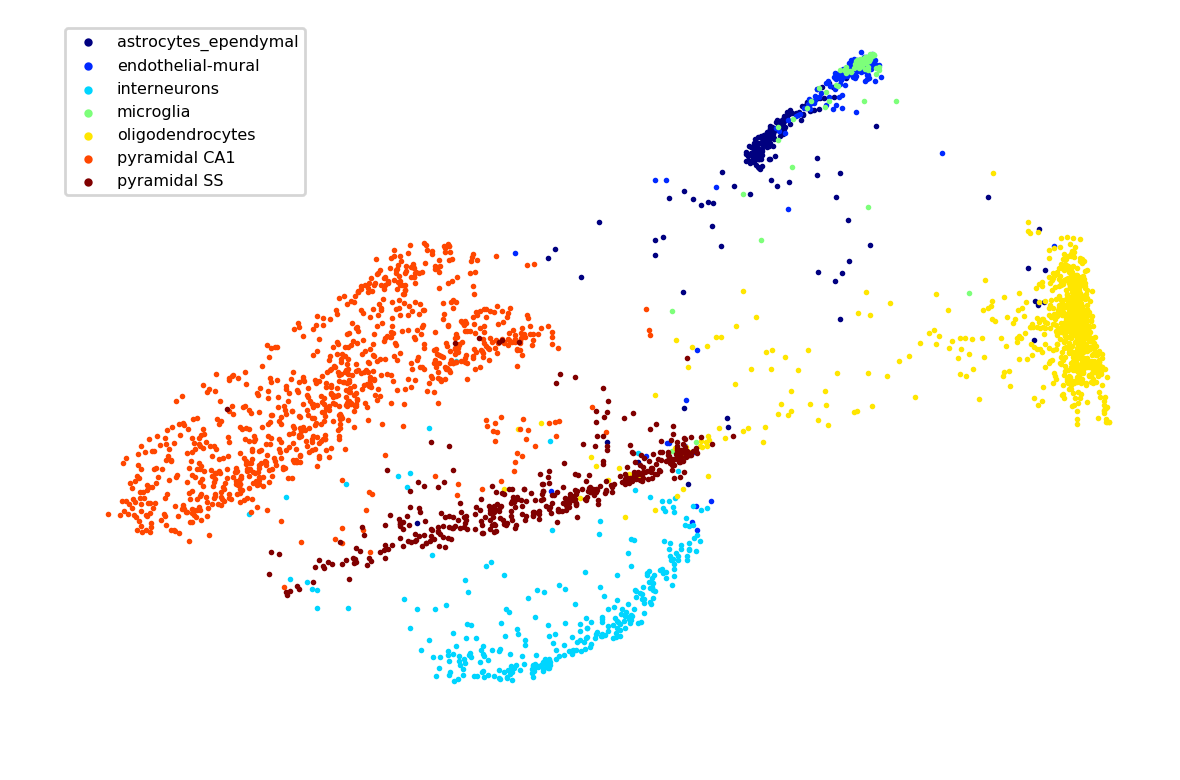

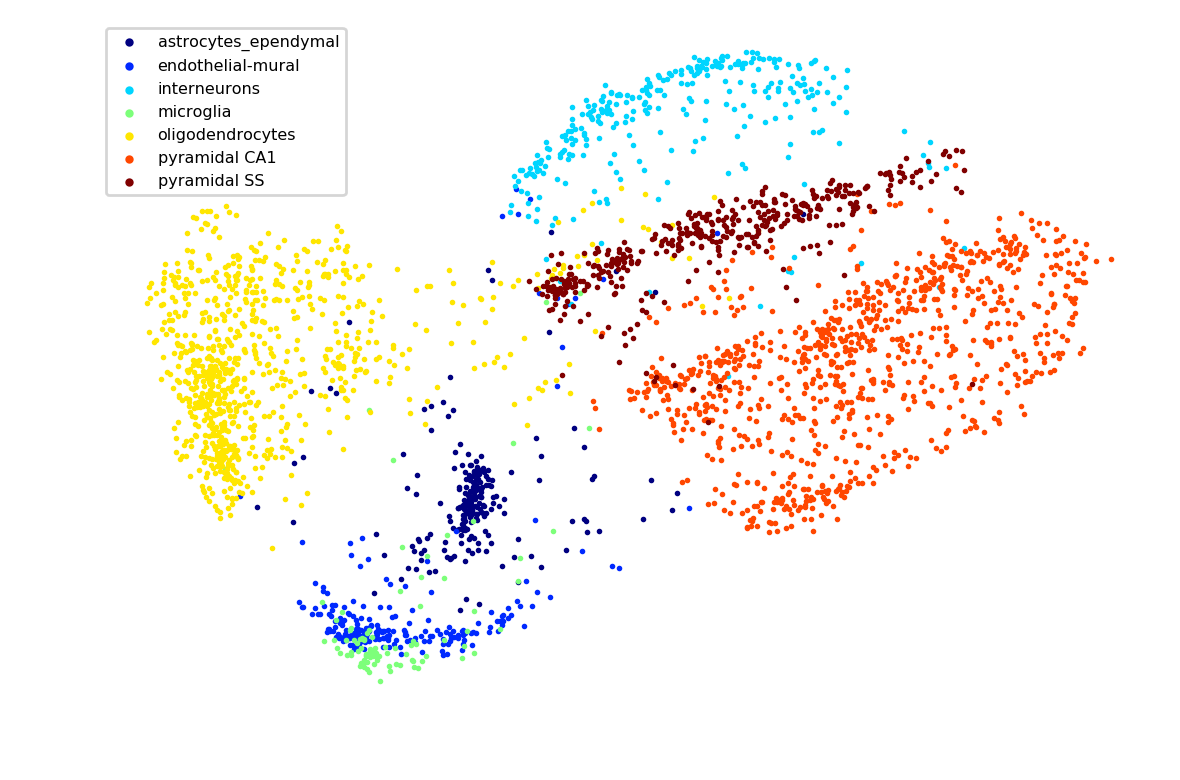

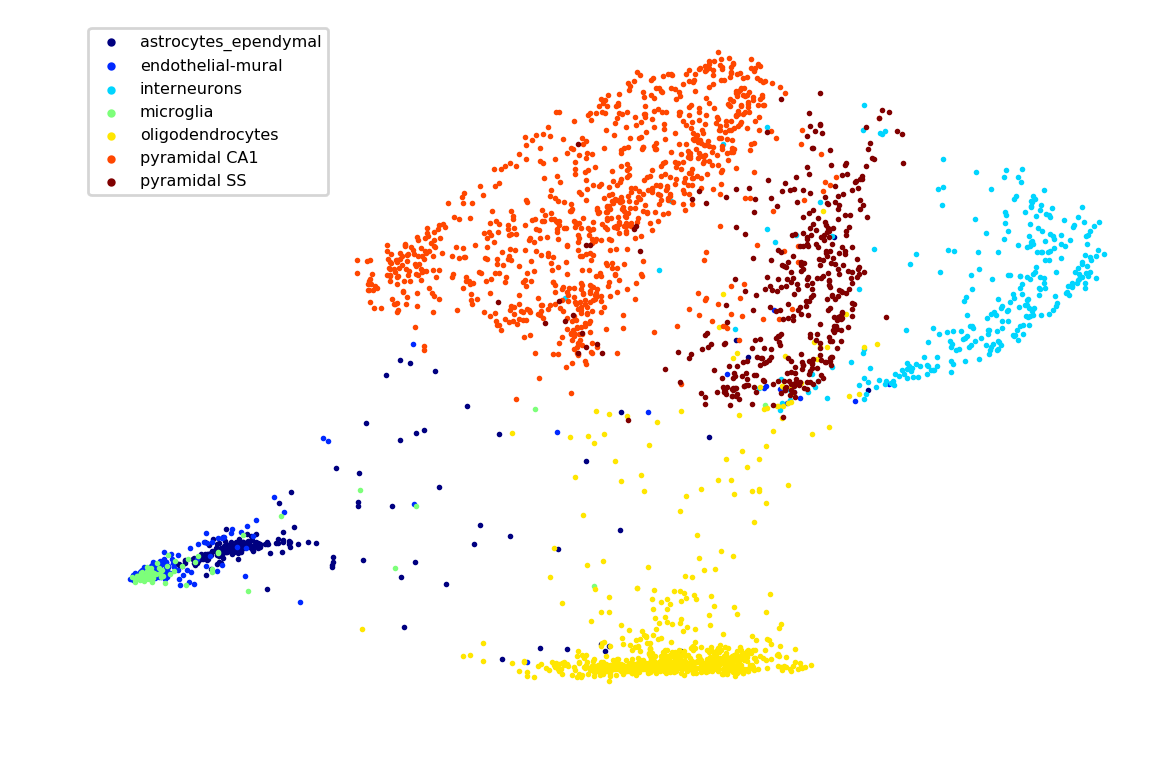

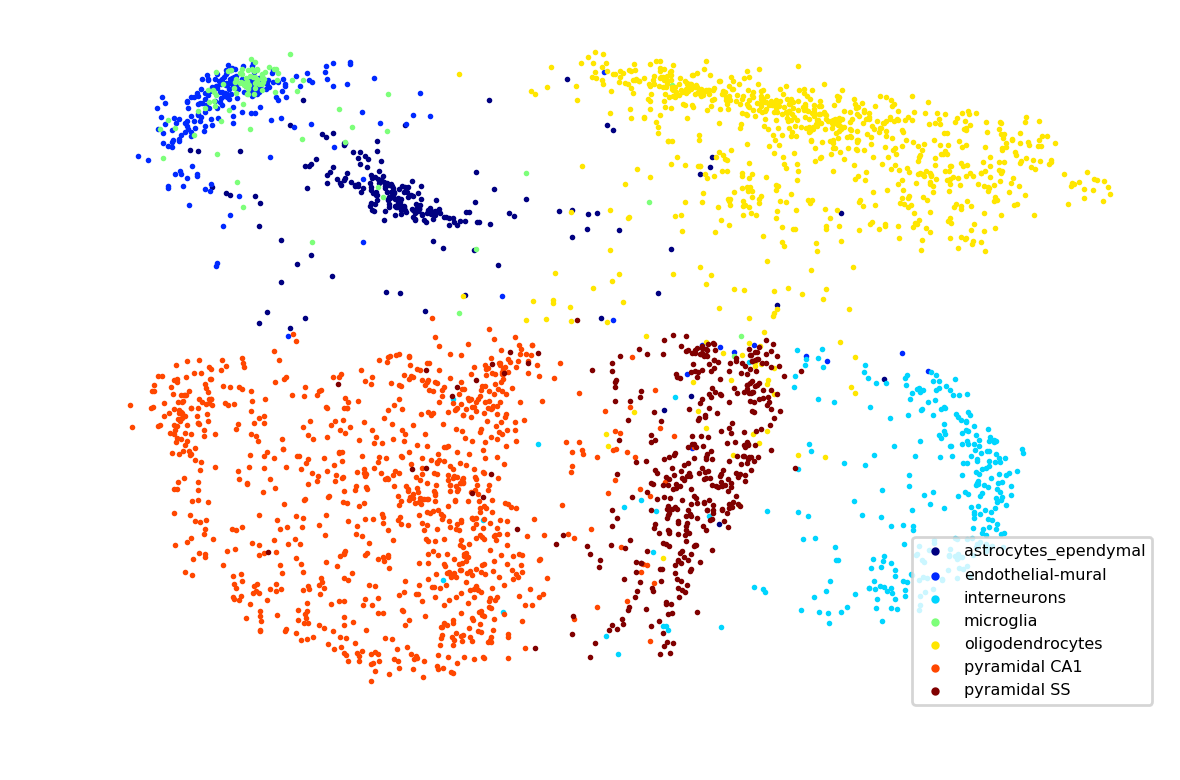

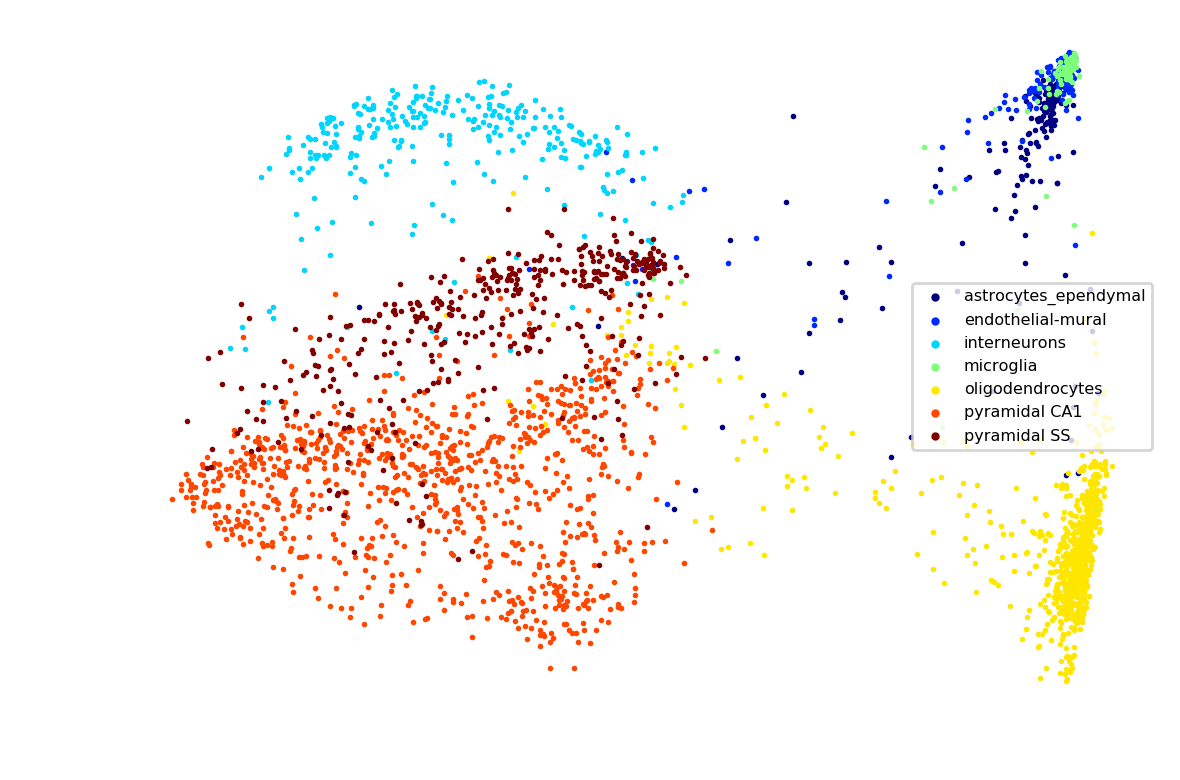

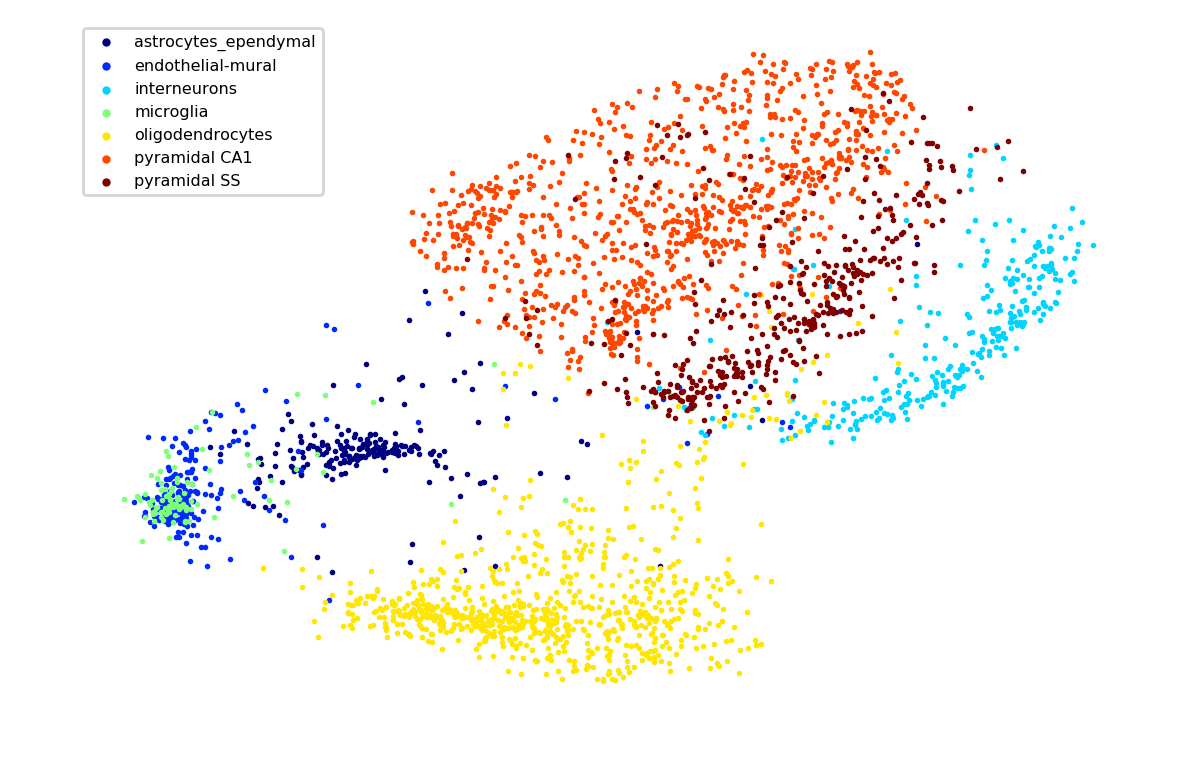

In [5]:
N_smalls = [1.0, 0.5, 0.25]
N_str = ["nobatch", "2batches", "4batches"]
lams = [1, 10]

cortex_dataset.affinity(perplexity=30.0)
for i in range(len(N_smalls)):
    cortex_dataset.affinity_split(N_small=N_smalls[i], perplexity=30.0)
    for lam in lams:
        NEE = NeuralEE(cortex_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        np.save('embedding/CORTEX_' + 'lam' + str(lam) + '_' + N_str[i], results_Neural['X'].numpy())
        scatter(results_Neural['X'].numpy(), NEE.labels, 
                cortex_dataset.cell_types)